In [1]:
import netCDF4 as nc
import numpy as np
import iris.coords as coords
import cf_units
import iris.cube as icube
import pdb
from scipy.stats import kurtosis
from scipy import stats
import seaborn as sns
import scipy.stats as stats
import random
import matplotlib.pyplot as plt
import math
import numpy.ma as ma
import datetime as dt
import iris.plot as iplt
import matplotlib as mpl
import iris
# import functions
from FidelityTest import calcDistrStatistic, timeseries_fid_test, plot_fidelity_testing, get_cube_limits, plotStatsMeasures,fidelity_testing_compare
from BiasCorrection import mean_bias_correction, kurtosis_power_transform, ratio_correction,Quantile_mapping,ks_compare_distributions,mean_correction, calculate_return_periods,plot_return_periods

In [2]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_model_DePreSys3.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model3 = summer_tem_model.variables['air_temperature'][:]
tem_model3.shape

(2, 30, 40)

In [3]:
# load model data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_model_DePreSys4.nc'  
summer_tem_model = nc.Dataset(file_path, mode='r')
summer_tem_model.variables.keys()
tem_model4 = summer_tem_model.variables['tas'][:]
tem_model4.shape

(10, 30, 10)

In [4]:
# load obs data
file_path = '/Users/evayang/Documents/dissertation/data/Hunan_summer_tas_obs_ERA5-Land.nc'  
summer_tem_obs = nc.Dataset(file_path, mode='r')
summer_tem_obs.variables.keys()
tem_obs = summer_tem_obs.variables['t2m'][:]
tem_obs.shape

(30,)

In [5]:
# reshape simulations from 3 dimensions to 2 dimensions
def reshape_model(simulations):  
    # reshape model simulations
    n_ensembles = simulations.shape[1]  
    n_months = simulations.shape[2]  
    model = simulations[:].reshape(n_ensembles, -1)
    return model

In [6]:
model3 = reshape_model(tem_model3)
model4 = reshape_model(tem_model4)
model4.shape

(30, 100)

In [7]:
# create cube for plotting
def convert_array_cube(data):
    time_coord = coords.DimCoord(range(data.shape[0]), standard_name='time')
    if data.ndim > 1:
        year_coord = coords.DimCoord(range(data.shape[1]), standard_name='realization')
        # define units for each coord
        year_coord.units = cf_units.Unit('years since 1992', calendar='gregorian')
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0), (year_coord, 1)])
    else:
        cube = iris.cube.Cube(data, dim_coords_and_dims=[(time_coord, 0)])
    cube.long_name = 'Hunan_Summer_data'
    cube.units = 'celsius'
    return cube

In [8]:
mod3 = convert_array_cube(model3)
mod4 = convert_array_cube(model4)
obs = convert_array_cube(tem_obs)
mod4

Hunan Summer Data (celsius),time,realization
Shape,30,100
Dimension coordinates,,
time,x,-
realization,-,x


In [11]:
def plotting_obs_mod(obs, mod, mod_corrected):
    obs_data = obs.data
    mod_data = mod.data
    mod_corrected_data = mod_corrected
    years = np.arange(1992, 2022)
    mod_mean = mod_data.mean(axis=1)
    mod_std = mod_data.std(axis=1)   
    mod_corrected_mean = mod_corrected_data.mean(axis=1)
    mod_corrected_std = mod_corrected_data.std(axis=1)
    fig, axes = plt.subplots(1, 2, figsize=(20, 8))
    axes[0].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_data.shape[1]):
        axes[0].plot(years, mod_data[:, i], color='grey', alpha=0.2)
    axes[0].plot(years, mod_mean, label='DePreSys3_mean', color='red', linewidth=2, linestyle='--')
    axes[0].set_xlabel('Year')
    axes[0].set_ylabel('Temperature')
    axes[0].set_title('Original Model')
    axes[0].legend()
    axes[1].plot(years, obs_data, label='Observations', color='black', linewidth=2, linestyle='--')
    for i in range(mod_corrected_data.shape[1]):
        axes[1].plot(years, mod_corrected_data[:, i], color='grey', alpha=0.2)
    axes[1].plot(years, mod_corrected_mean, label='DePreSys3_corrected_mean', color='blue', linewidth=2, linestyle='--')
    axes[1].set_xlabel('Year')
    axes[1].set_ylabel('Temperature')
    axes[1].set_title('Corrected Model')
    axes[1].legend()
    plt.tight_layout()
    plt.show()

In [ ]:
print("Hunan Summer Temperature for DePreSys3 Data:")
plotting_obs_mod(obs, mod3, model3_meancor)
print("Hunan Summer Temperature for DePreSys4 Data:")
plotting_obs_mod(obs, mod4, model4_meancor)

## Fidelity Test

In [13]:
print("(1) result of fidelity testing for DePreSys3 data:\n")
stats_measures3=timeseries_fid_test(obs.data,model3)
print("\n(2) result of fidelity testing for DePreSys4 data:\n")
stats_measures4=timeseries_fid_test(obs.data,model4)

(1) result of fidelity testing for DePreSys3 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 53.959999999999994
Skewness perc: 29.189999999999998
Kurtosis perc: 10.299999999999999
Linear trend perc: 96.19

(2) result of fidelity testing for DePreSys4 data:

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 4.25
Skewness perc: 51.27
Kurtosis perc: 20.419999999999998
Linear trend perc: 99.53


In [ ]:
plot_fidelity_testing(obs.data, model3, stats_measures3, 0.1,"fidelity test for DePreSys3 temperature data","1.png")

plotting


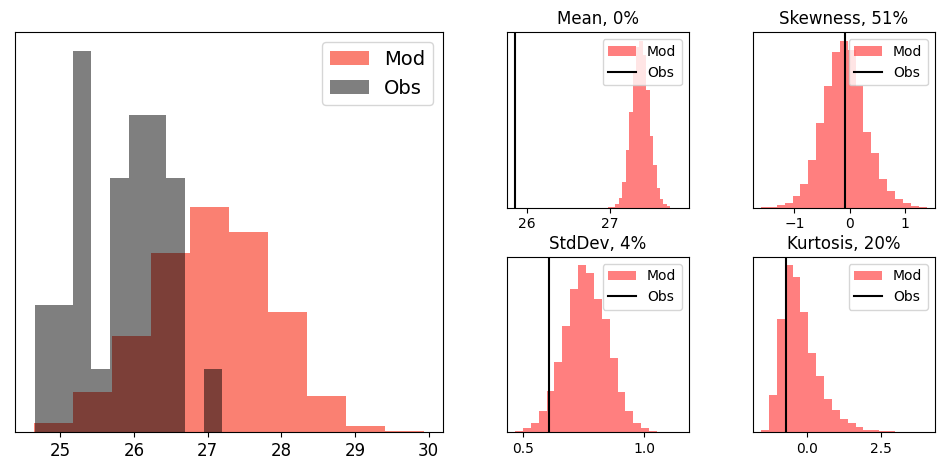

In [15]:
plot_fidelity_testing(obs.data, model4, stats_measures4, 0.1,"","2.png")

## Bias Correction

### 1) DePreSys3 Data : 

In [16]:
model3_meancor= mean_bias_correction(obs.data, mod3.data)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 21.82
Standard deviation perc: 54.11
Skewness perc: 28.79
Kurtosis perc: 10.65
Linear trend perc: 96.45
plotting


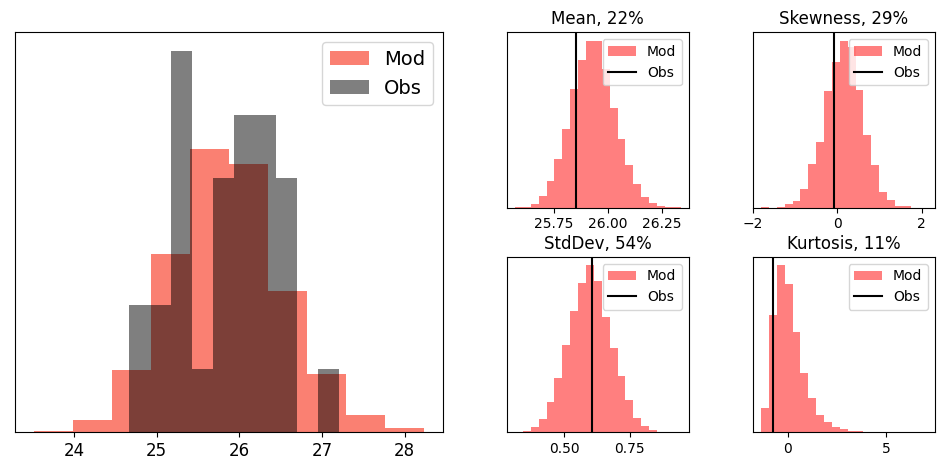

In [17]:
stats_measures_cor3=timeseries_fid_test(obs.data,model3_meancor)
plot_fidelity_testing(obs.data, model3_meancor, stats_measures_cor3, 0.1,"","1.png")

In [18]:
model3_kurtcor = kurtosis_power_transform(model3)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.0
Standard deviation perc: 51.94
Skewness perc: 29.659999999999997
Kurtosis perc: 68.02
Linear trend perc: 96.46000000000001
plotting


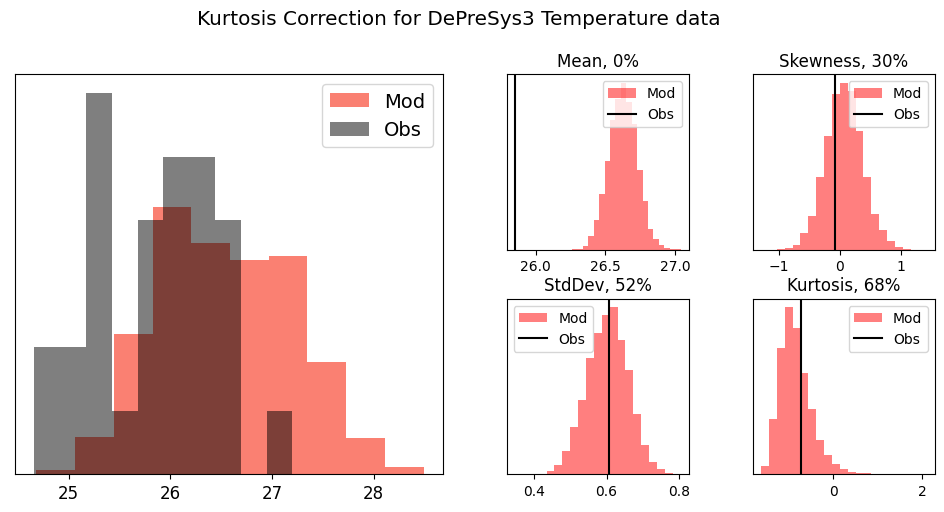

In [19]:
stats_measures_cor3=timeseries_fid_test(obs.data,model3_kurtcor)
plot_fidelity_testing(obs.data, model3_kurtcor, stats_measures_cor3, 0.1,"Kurtosis Correction for DePreSys3 Temperature data  ","1.png")

### 2) DePreSys4 Data Bias Correction:

plotting


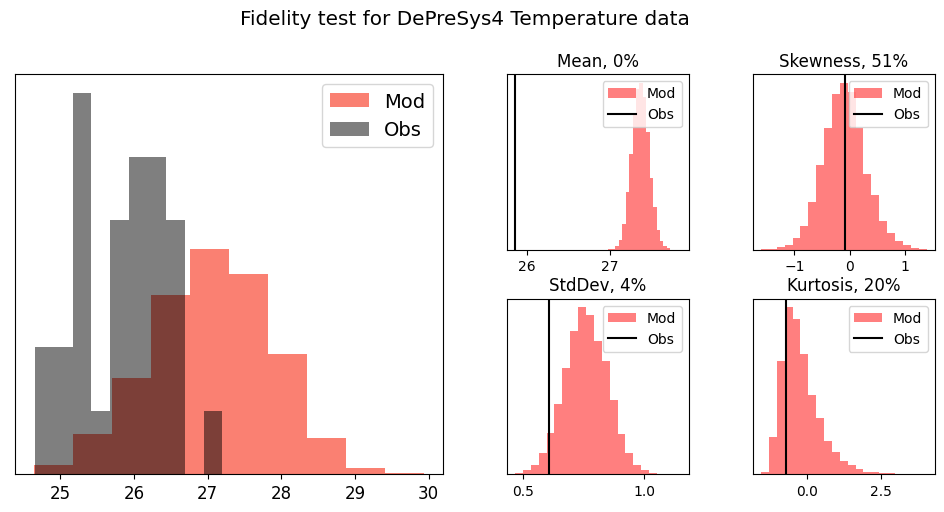

In [20]:
plot_fidelity_testing(obs.data, mod4.data, stats_measures4, 0.1,"Fidelity test for DePreSys4 Temperature data","2.png")

In [21]:
model4_meancor= ratio_correction(obs.data, mod4.data)
print("mod mean:",mod4.data.mean())
print("mod_cor mean:",model4_meancor.mean())
print("obs mean",obs.data.mean())

mod mean: 27.05304104789102
mod_cor mean: 25.852407660620063
obs mean 25.852407660620063


Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.06
Standard deviation perc: 71.63000000000001
Skewness perc: 53.26
Kurtosis perc: 19.77
Linear trend perc: 99.98
plotting


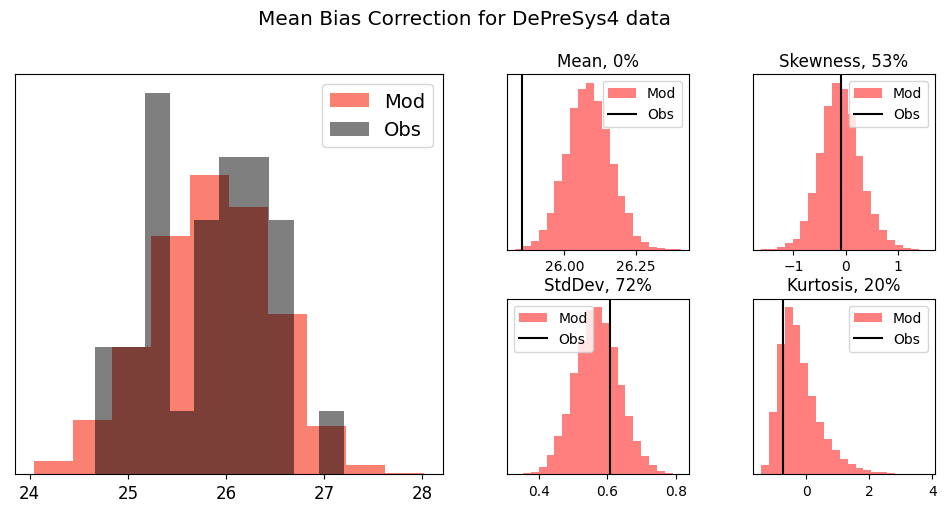

In [22]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_meancor)
plot_fidelity_testing(obs.data, model4_meancor, stats_measures_cor4, 0.1,"Mean Bias Correction for DePreSys4 data","1.png")

In [23]:
model4_kurtcor = kurtosis_power_transform(model4_meancor)

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.13999999999999999
Standard deviation perc: 75.42999999999999
Skewness perc: 53.31
Kurtosis perc: 42.74
Linear trend perc: 99.99
plotting


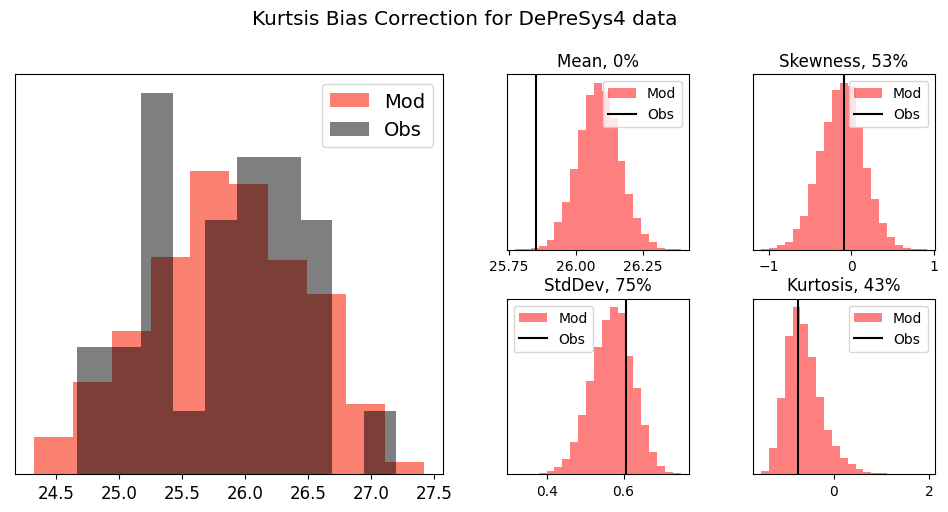

In [24]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_kurtcor)
plot_fidelity_testing(obs.data, model4_kurtcor, stats_measures_cor4, 0.1,"Kurtsis Bias Correction for DePreSys4 data","1.png")

Fidelity testing
calculating distribution statistics
calculating percentiles
Mean perc: 0.06
Standard deviation perc: 72.27
Skewness perc: 52.39
Kurtosis perc: 20.080000000000002
Linear trend perc: 99.99
plotting


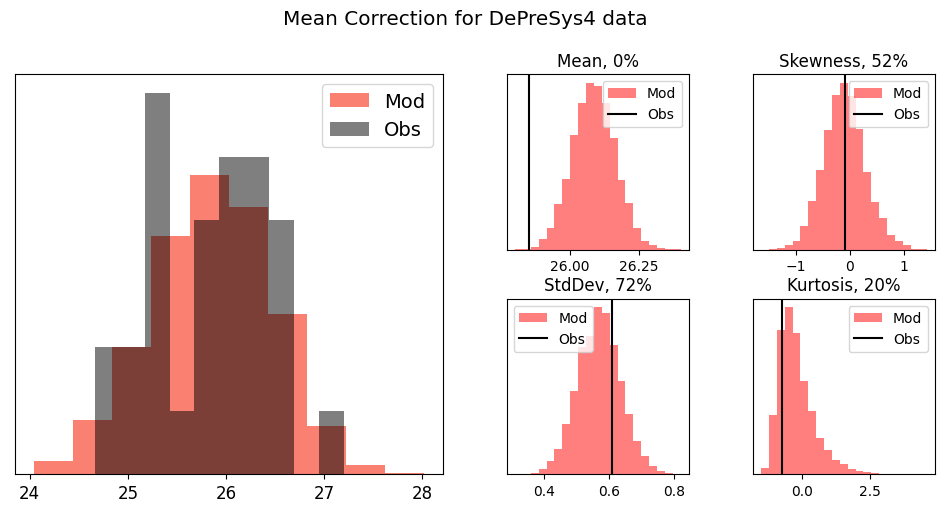

In [27]:
stats_measures_cor4=timeseries_fid_test(obs.data,model4_meancor)
plot_fidelity_testing(obs.data, model4_meancor, stats_measures_cor4, 0.1,"Mean Correction for DePreSys4 data","1.png")

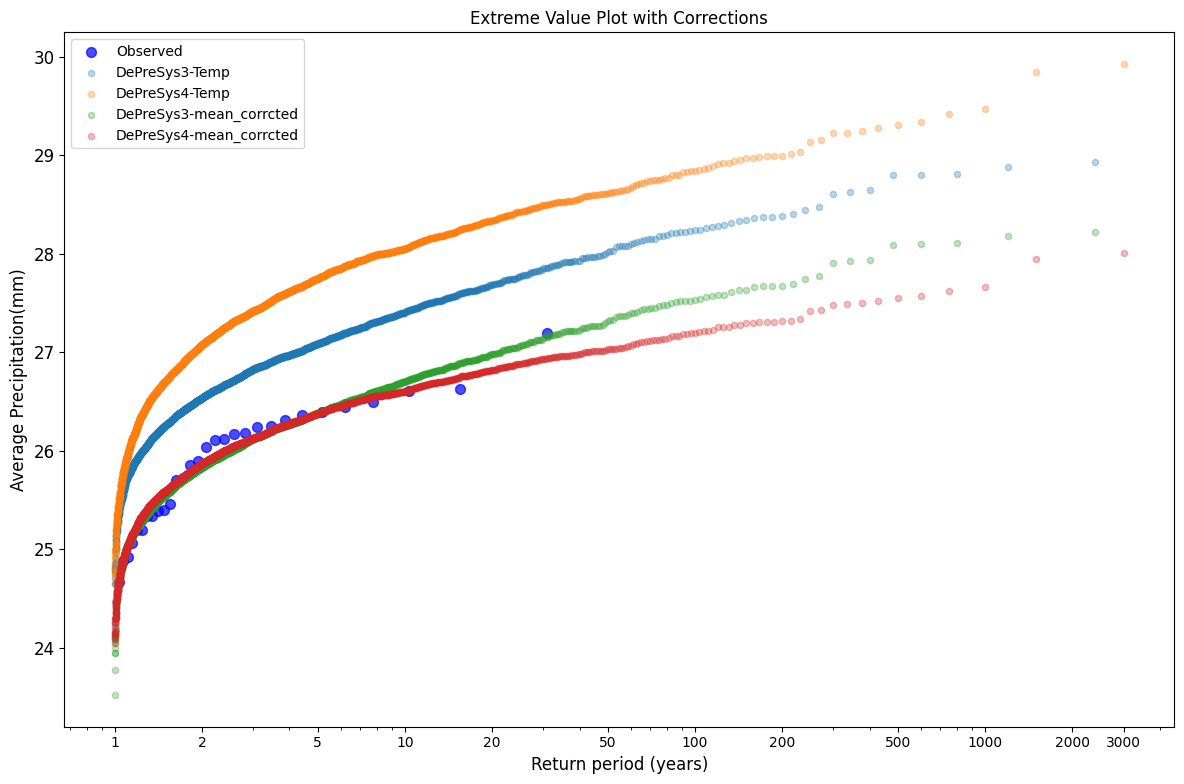

In [28]:
# comparison in return periods
obs_data = obs.data
models_data = [mod3.data, mod4.data, model3_meancor,model4_meancor]
model_names = ['DePreSys3-Temp', 'DePreSys4-Temp', 'DePreSys3-mean_corrcted','DePreSys4-mean_corrcted']
plot_return_periods(obs_data, models_data, model_names, n_years=30)

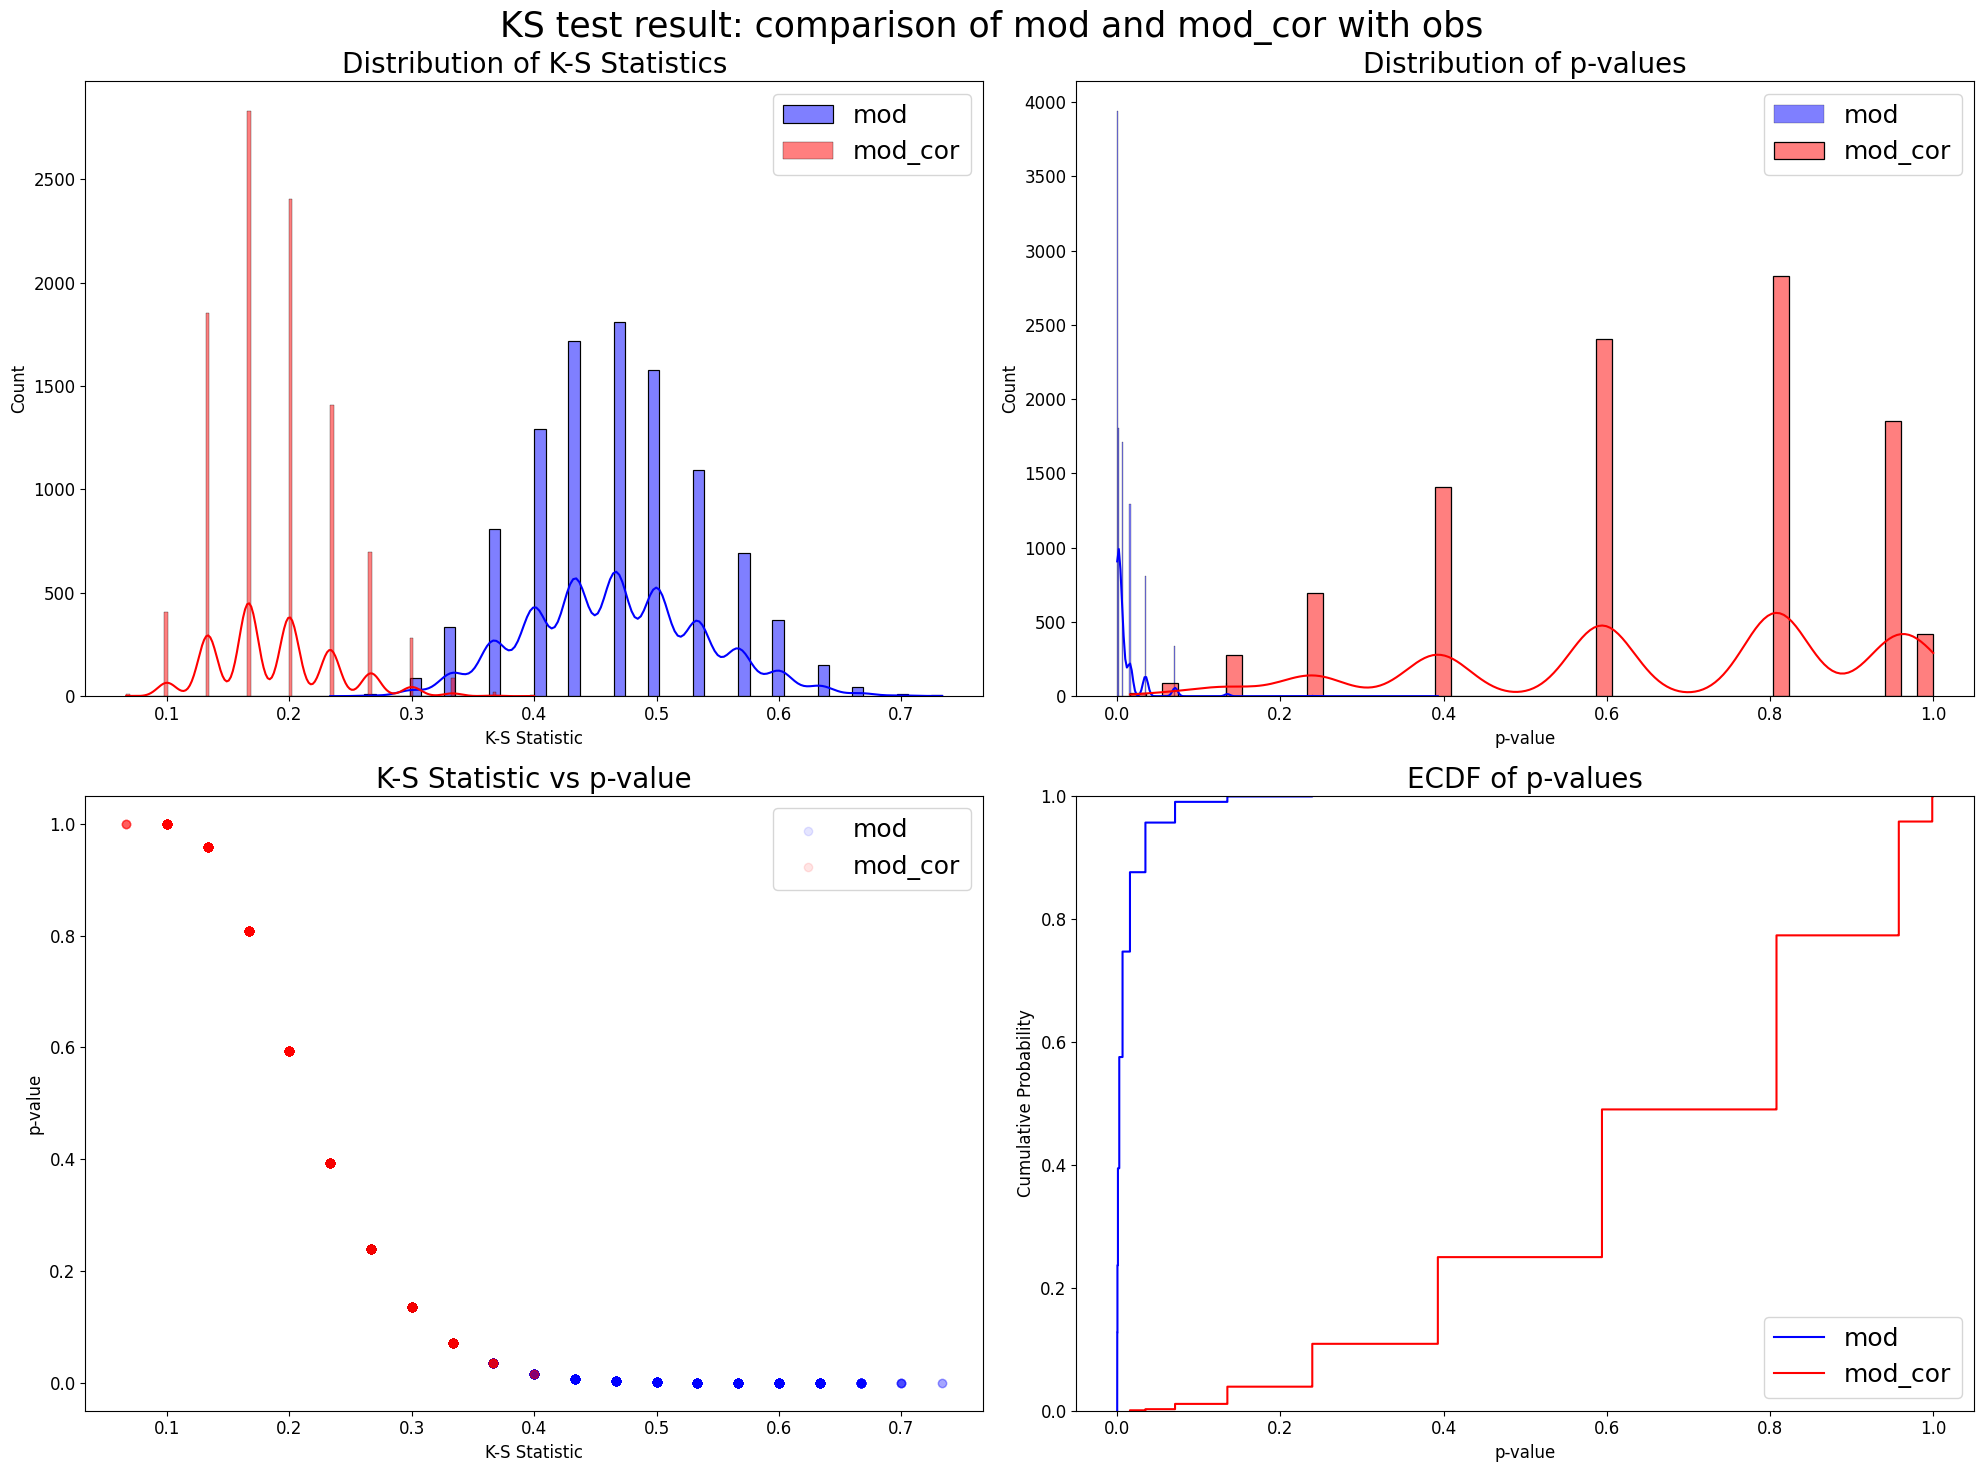

Summary for mod:
Mean K-S Statistic: 0.4663
Mean p-value: 0.0104
Proportion of significant results (p < 0.05): 95.65%


Summary for mod_cor:
Mean K-S Statistic: 0.1877
Mean p-value: 0.6670
Proportion of significant results (p < 0.05): 0.25%


In [29]:
ks_compare_distributions(obs.data, mod3.data,model3_meancor)

## AD test

In [30]:
def ensemble_bootstrap(mod_data, n_samples=10000):
    years, ensembles = mod_data.shape
    all_samples = np.zeros((years, n_samples))
    for i in range(n_samples):
        for year in range(years):
            ensemble = np.random.choice(ensembles)
            all_samples[year, i] = mod_data[year, ensemble]

    return all_samples

In [31]:
def perform_anderson_darling_test(obs_data, sample_data):
    p_values = []
    for i in range(sample_data.shape[1]):
        sample = sample_data[:, i]
        try:
            result = stats.anderson_ksamp([obs_data, sample])
            if isinstance(result, tuple):
                p_value = result[2]  
            else:
                p_value = result.significance_level
            p_values.append(p_value)
        except ValueError as e:
            print(f"Error in sample {i}: {e}")
            p_values.append(np.nan)    
    return np.array(p_values)



In [32]:
# A-D test
bootstrap_samples = ensemble_bootstrap(mod4.data, n_samples=10000)
print("bootstrap_samples shape:", mod4.data.shape)
p_values = perform_anderson_darling_test(obs.data, mod4.data)
proportion_consistent = np.mean(p_values > 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent:.3%}")


bootstrap_samples1 = ensemble_bootstrap(model4_meancor, n_samples=10000)
print("bootstrap_samples shape:", model4_meancor.shape)
p_values1 = perform_anderson_darling_test(obs.data, model4_meancor)
proportion_consistent1 = np.mean(p_values1 > 0.05)
print(f"Proportion of simulations consistent with observations: {proportion_consistent1:.3%}")


bootstrap_samples shape: (30, 100)
Proportion of simulations consistent with observations: 0.000%


/var/folders/7n/j4hlxg310p57b6kw3wfmm_w80000gn/T/ipykernel_2409/2985888911.py:6: UserWarning: p-value floored: true value smaller than 0.001
  result = stats.anderson_ksamp([obs_data, sample])


bootstrap_samples shape: (30, 100)
Proportion of simulations consistent with observations: 94.000%


/var/folders/7n/j4hlxg310p57b6kw3wfmm_w80000gn/T/ipykernel_2409/2985888911.py:6: UserWarning: p-value capped: true value larger than 0.25
  result = stats.anderson_ksamp([obs_data, sample])


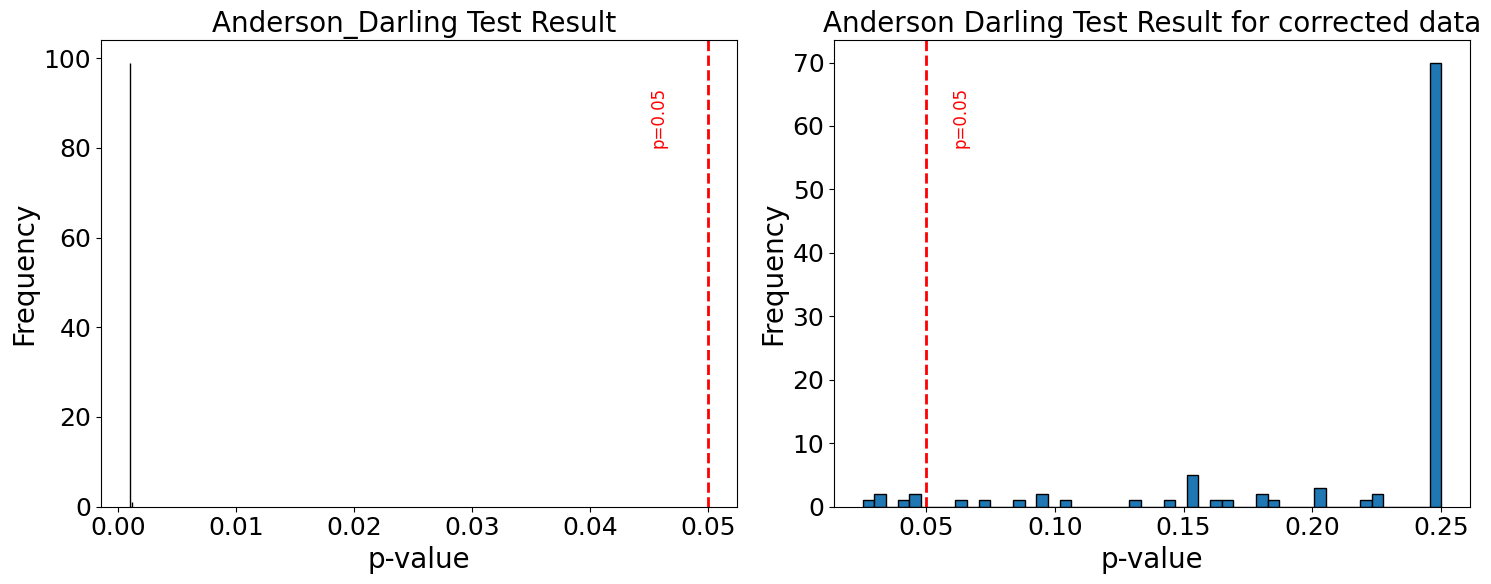

0.0011610873366277533

In [33]:
plt.figure(figsize=(15, 6))
plt.subplot(121)
plt.hist(p_values, bins=50, edgecolor='black')
plt.title('Anderson_Darling Test Result ')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.045, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')

plt.subplot(122)
plt.hist(p_values1, bins=50, edgecolor='black')
plt.title('Anderson Darling Test Result for corrected data')
plt.xlabel('p-value')
plt.ylabel('Frequency')
plt.axvline(0.05, color='r', linestyle='dashed', linewidth=2)
plt.text(0.06, plt.ylim()[1]*0.9, 'p=0.05', color='r', rotation=90, va='top')
plt.tight_layout()
plt.show()
p_values.max()

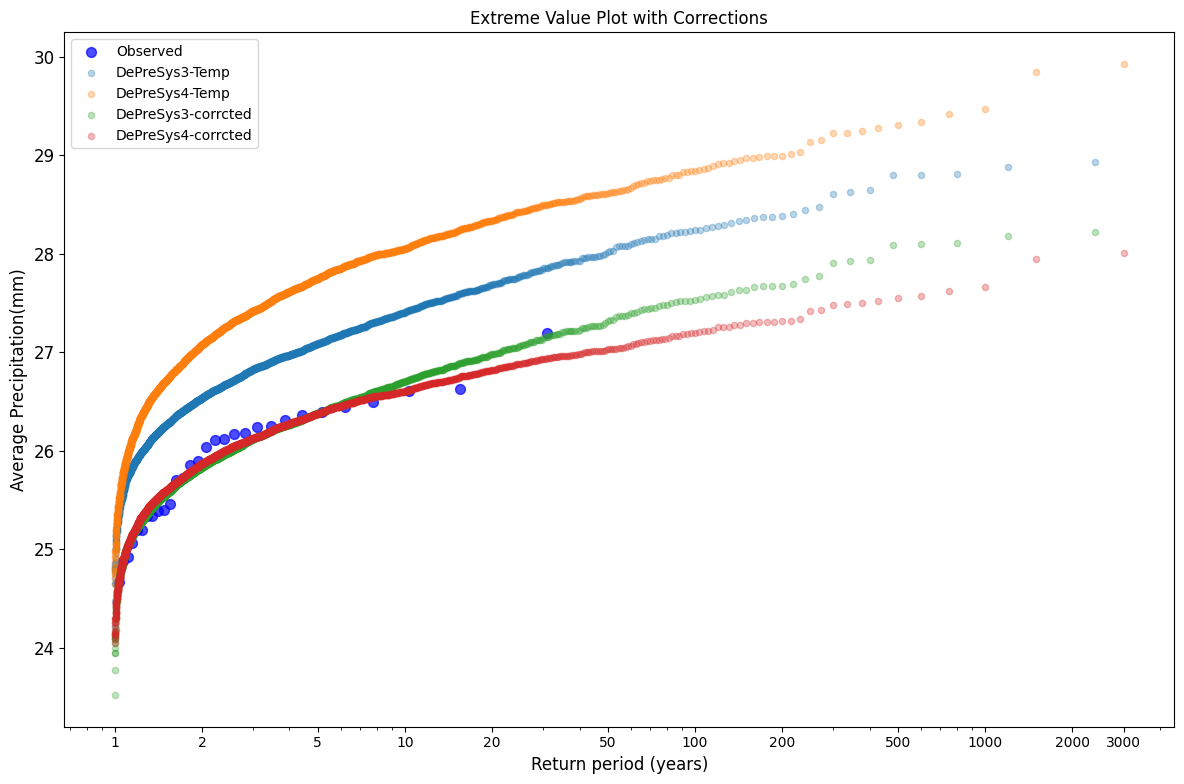

In [35]:
# comparison in return periods
obs_data = obs.data
models_data = [mod3.data,mod4.data, model3_meancor, model4_meancor]
model_names = [ 'DePreSys3-Temp','DePreSys4-Temp','DePreSys3-corrcted','DePreSys4-corrcted']
plot_return_periods(obs_data, models_data, model_names, n_years=30)

# Analysis

In [44]:

print("Mod max:", np.max(mod3.data))
print("Mod max:", np.max(model3_meancor))
print("Mod min:", np.min(model3_meancor))
print("Mod mean:", np.mean(model3_meancor))
#obs = obs.data
mod = model3_meancor

Mod max: 28.932973273559707
Mod max: 28.22719117227649
Mod min: 23.51800041535886
Mod mean: 25.852407660620067


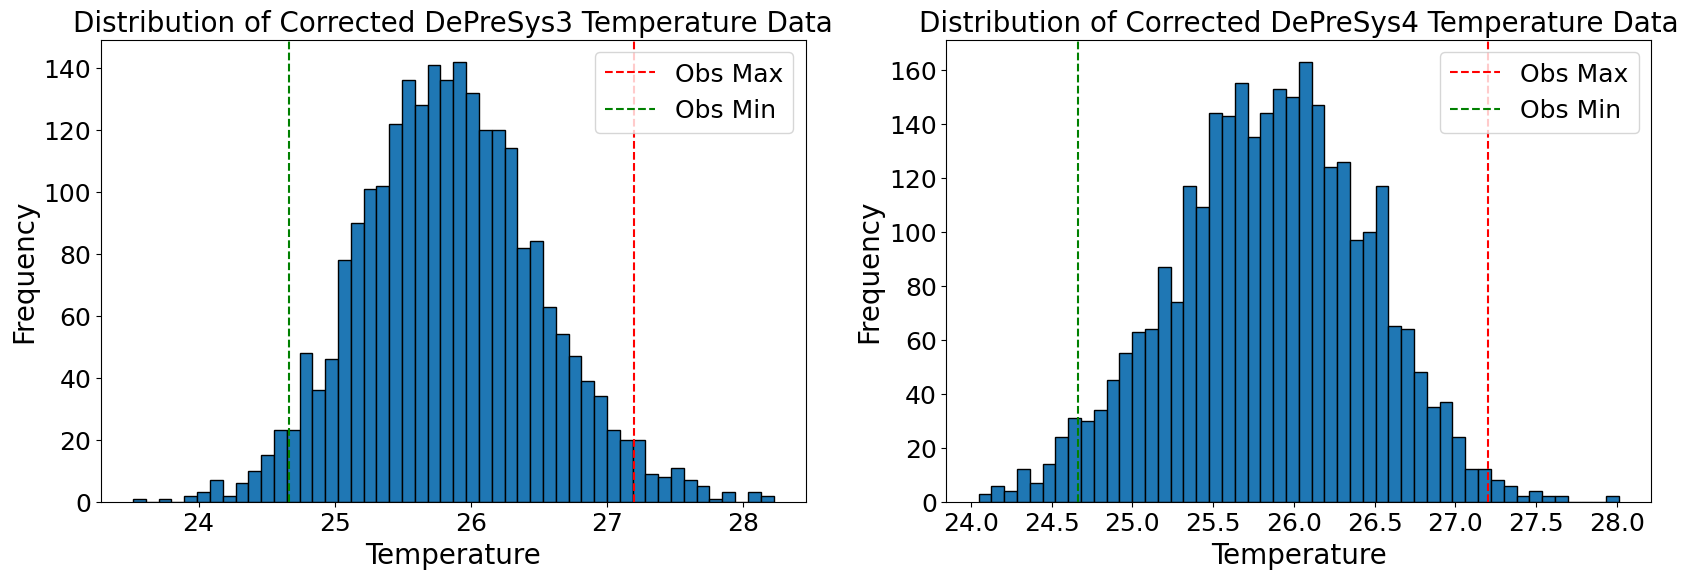

In [45]:
obs_max = np.max(obs.data)
obs_min = np.min(obs.data)
fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 6))

# 第一个子图：完整的mod分布
ax1.hist(model3_meancor.flatten(), bins=50, edgecolor='black')
ax1.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax1.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax1.set_xlabel('Temperature')
ax1.set_ylabel('Frequency')
ax1.set_title('Distribution of Corrected DePreSys3 Temperature Data')
ax1.legend()

ax2.hist(model4_meancor.flatten(), bins=50, edgecolor='black')
ax2.axvline(obs_max, color='red', linestyle='--', label='Obs Max')
ax2.axvline(obs_min, color='green', linestyle='--', label='Obs Min')
ax2.set_xlabel('Temperature')
ax2.set_ylabel('Frequency')
ax2.set_title('Distribution of Corrected DePreSys4 Temperature Data')
ax2.legend()

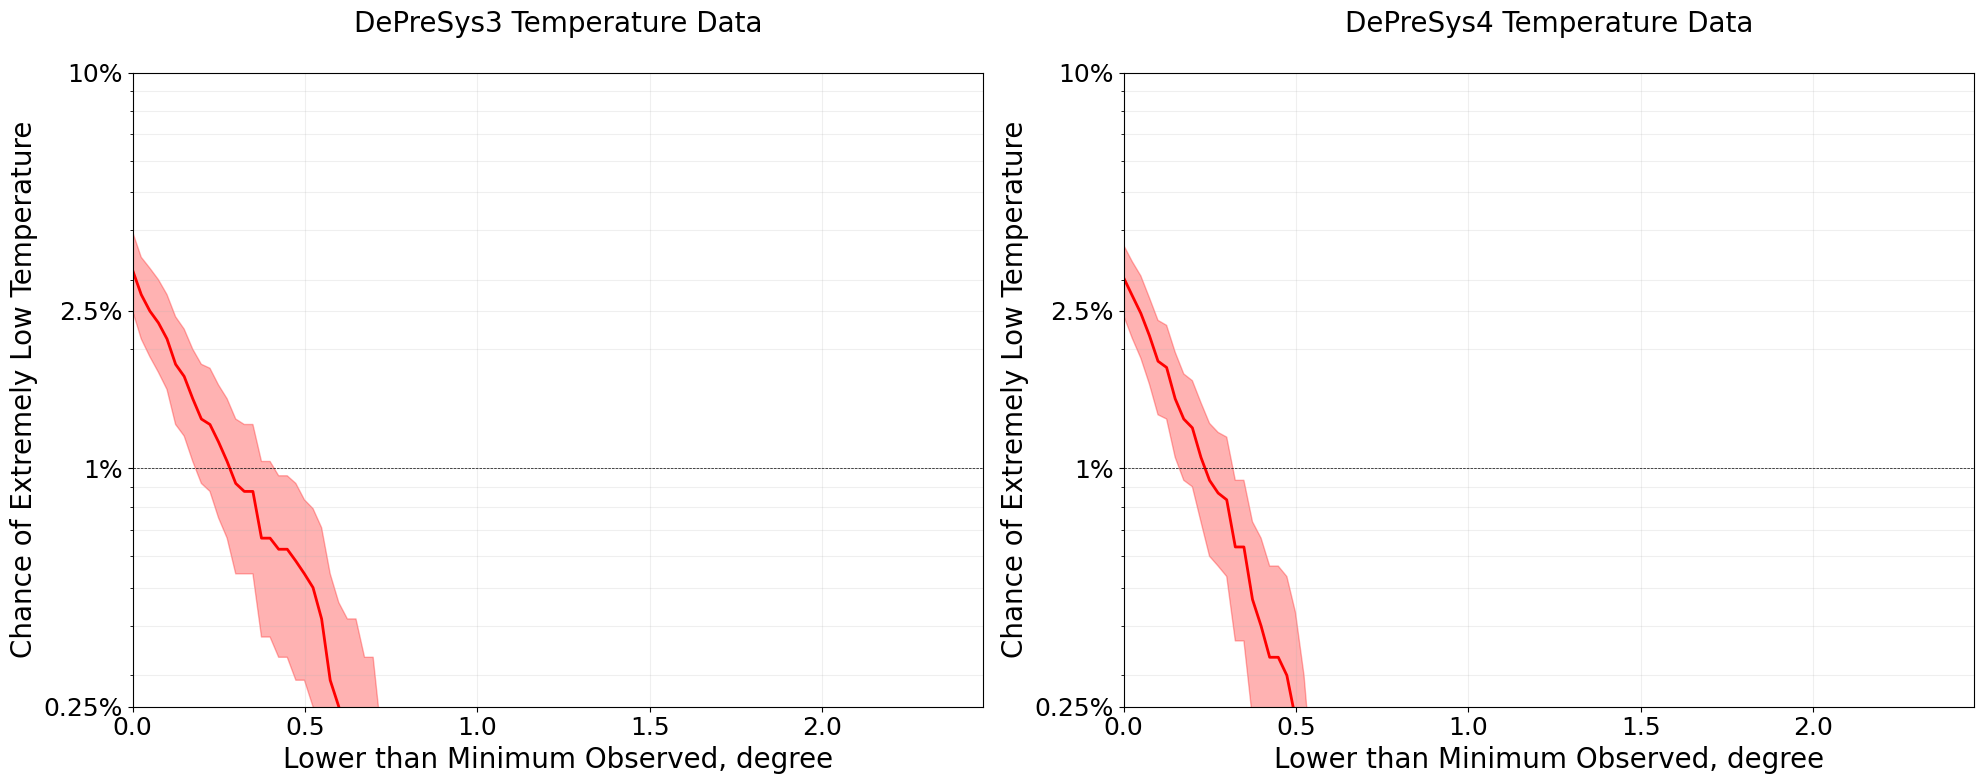

DePreSys3:
Chance of being below the observed minimum: 3.17%
Chance of being below the observed minimum by 1 degree: 0.04%

DePreSys4:
Chance of being below the observed minimum: 3.03%
Chance of being below the observed minimum by 1 degree: 0.00%


In [46]:
def calculate_below_minimum_probability(data, threshold, temp_decrements):
    probs = []
    for temp in temp_decrements:
        prob = np.mean(data.flatten() <= (threshold - temp)) * 100
        probs.append(prob)
    return probs

def plot_below_minimum_probability(ax, mod, obs, title):
    obs_min = np.min(obs)
    max_decrement = obs_min * 0.1
    temp_decrements = np.linspace(0, max_decrement, 100)
    
    probabilities = calculate_below_minimum_probability(mod, obs_min, temp_decrements)
    
    n_bootstrap = 1000
    bootstrap_results = []
    for _ in range(n_bootstrap):
        bootstrap_sample = np.random.choice(mod.flatten(), size=mod.size, replace=True)
        bootstrap_probs = calculate_below_minimum_probability(bootstrap_sample, obs_min, temp_decrements)
        bootstrap_results.append(bootstrap_probs)
    
    lower_bound = np.percentile(bootstrap_results, 2.5, axis=0)
    upper_bound = np.percentile(bootstrap_results, 97.5, axis=0)
    
    ax.plot(temp_decrements, probabilities, color='red', linewidth=2)
    ax.fill_between(temp_decrements, lower_bound, upper_bound, color='red', alpha=0.3)
    ax.set_xlabel('Lower than Minimum Observed, degree')
    ax.set_ylabel('Chance of Extremely Low Temperature')
    ax.set_yscale('log')
    ax.set_ylim(0.25, 10)
    ax.set_xlim(0, max_decrement)
    ax.set_yticks([0.25, 1, 2.5, 10])
    ax.set_yticklabels(['0.25%', '1%', '2.5%', '10%'])
    ax.grid(True, which="both", ls="-", alpha=0.2)
    ax.set_title(title)
    ax.axhline(y=1, color='black', linestyle='--', linewidth=0.5)
    
    return probabilities, temp_decrements

fig, (ax1, ax2) = plt.subplots(1, 2, figsize=(20, 8))
prob1, temp_decrements1 = plot_below_minimum_probability(ax1, model3_meancor, obs.data, 'DePreSys3 Temperature Data\n')
prob2, temp_decrements2 = plot_below_minimum_probability(ax2, model4_meancor, obs.data, 'DePreSys4 Temperature Data\n')
plt.tight_layout()
plt.show()

print("DePreSys3:")
print(f"Chance of being below the observed minimum: {prob1[0]:.2f}%")
print(f"Chance of being below the observed minimum by 1 degree: {prob1[np.argmin(np.abs(temp_decrements1 - 1))]:.2f}%")
print("\nDePreSys4:")
print(f"Chance of being below the observed minimum: {prob2[0]:.2f}%")
print(f"Chance of being below the observed minimum by 1 degree: {prob2[np.argmin(np.abs(temp_decrements2 - 1))]:.2f}%")